In [37]:
import control as ctl
from control.matlab import *
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [38]:
class DiscreteTransferFunction(torch.nn.Module):
    def __init__(self, b, a, dt=1.0):
        super(DiscreteTransferFunction, self).__init__()
        self.b = torch.tensor(b, dtype=torch.float32)
        self.a = torch.tensor(a, dtype=torch.float32)
        self.dt = dt

    def forward(self, r):
        # Ensure the input is a tensor
        r = r.type(torch.float32)
        n = max(len(self.a), len(self.b))
        y = torch.zeros_like(r)

        # Compute the output using the difference equation
        for t in range(len(r)):
            for i in range(len(self.b)):
                if t - i >= 0:
                    y[t] += self.b[i] * r[t - i]
            for j in range(1, len(self.a)):
                if t - j >= 0:
                    y[t] -= self.a[j] * y[t - j]

        y = torch.cat((torch.tensor([0]), y[:-1]))

        return y * self.dt

In [39]:
import time

ts = 1
T = 100

# Define the coefficients for the transfer function
b = [1.0, -0.5]
a = [1.0, -1.5, 0.7]

tf_ctl = ctl.TransferFunction(b, a, dt=ts)

t = np.arange(0, T, ts)
r = np.ones_like(t)

start_time = time.time()
y_control = ctl.forced_response(tf_ctl, t, r)[1]
# Calculate the elapsed time
# Measure the end time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Computation Time: {elapsed_time:.6f} seconds")

Computation Time: 0.002520 seconds


In [40]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3090'

Computation Time: 0.007742 seconds


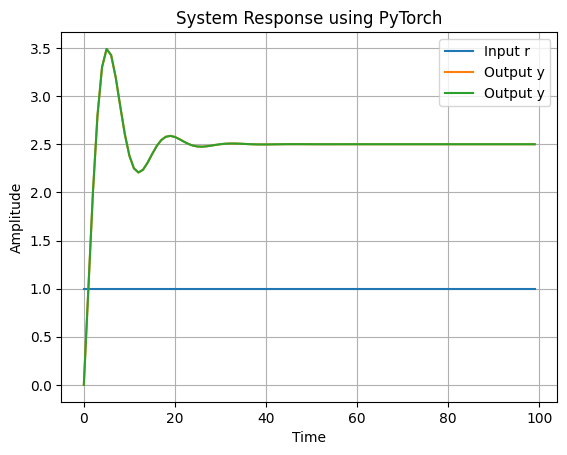

In [41]:
# Create the transfer function
tf_torch = DiscreteTransferFunction(b, a)

# Define the input signal (e.g., step function)
t = torch.arange(0, T, ts)
r = torch.ones_like(t)

# Compute the output
start_time = time.time()
y_torch = tf_torch(r)
# Measure the end time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Computation Time: {elapsed_time:.6f} seconds")

# Plot the response
plt.plot(t.numpy(), r.numpy(), label='Input r')
plt.plot(t.numpy(), y_torch.detach().numpy(), label='Output y')
plt.plot(t.numpy(), y_control, label='Output y')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.title('System Response using PyTorch')
plt.show()